# Clasificación multiclase

## Introduction

En este ejercicio se implementa la regresion one-vs-all y una red neuronal para reconocimiento de digitos.

Antes de empezar la ejecución de las partes de codigo correspondienters a los ejercicios, se requiere importar todas las librerias necesarias.

Dataset
https://www.kaggle.com/datasets/ilginkarakas/covtype

In [20]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.optimize import fmin_tnc

# modulo para cargar archivos en formato MATLAB
# from scipy.io import loadmat

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

Leer el dataset y definir numero de clases como entradas

In [21]:

input_layer_size  = 54

# 7 etiquetas, de 1 a 7 (tomar en cuenta que se asigna "0" a la etiqueta 7)
num_labels = 7
file_path = 'covtype.csv'
df = pd.read_csv(file_path)


In [22]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [23]:
# Separar las características (X) y los labels (Y)
X = df.iloc[:, :-1].values  # Todas las columnas excepto la primera
Y = df.iloc[:, -1].values   # Solo la primera columna (label)
m = Y.size

# Confirmar las dimensiones de X e Y
print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de Y: {Y.shape}")


Dimensiones de X: (581012, 54)
Dimensiones de Y: (581012,)


Normalizacion de los valores de x

In [24]:
def  featureNormalize(X):

    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [25]:
# Dividimos los datos en conjuntos para entrenamiento y para prueba
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Normalizar los datos de entrenamiento

In [26]:
X_norm, mu, sigma = featureNormalize(X_train)

In [27]:
print(f"Dimensiones de X: {X_train.shape}")
print(f"Dimensiones de Y: {Y_train.shape}")

Dimensiones de X: (464809, 54)
Dimensiones de Y: (464809,)




Se utiliza para "comprimir" cualquier número real a un rango entre 0 y 1, haciendo que sea útil para modelar probabilidades. Dada su forma en "S" o curva logística, la función sigmoide toma valores reales y los transforma en una salida que puede interpretarse como una probabilidad.

In [28]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

Costo (J): Mide qué tan bien el modelo con los parámetros actuales (theta) está prediciendo las etiquetas y a partir de los datos de entrada X
Gradiente (grad): Indica cómo deben ajustarse los parámetros theta para reducir el costo. Es esencial para algoritmos de optimización como el descenso por el gradiente

In [29]:
def lrCostFunction(theta, X, y, lambda_):

    # Inicializa algunos valores utiles
    m = y.size

    # convierte las etiquetas a valores enteros si son boleanos
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    # grad = (1 / m) * (h - y).dot(X)
    # grad = grad + (lambda_ / m) * temp

    grad = (1 / m) * (h - y).dot(X) + (lambda_ / m) * temp

    return J, grad

entrena clasificadores binarios para cada clase en un problema multiclase y devuelve los parámetros aprendidos para cada uno

In [30]:
def oneVsAll(X, y, num_labels, lambda_):
    # algunas variables utiles
    m, n = X.shape

    # print(m, n)
    all_theta = np.zeros((num_labels, n + 1))

    # Agrega unos a la matriz X
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        # print(res)
        all_theta[c] = res.x

    return all_theta

In [31]:
lambda_ = 0.001
all_theta = oneVsAll(X_train, Y_train, num_labels, lambda_)

C:\Users\david\AppData\Local\Temp\ipykernel_19628\2831633526.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_19628\1207231430.py:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
C:\Users\david\AppData\Local\Temp\ipykernel_19628\1207231430.py:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
C:\Users\david\AppData\Local\Temp\ipykernel_19628\2831633526.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_19628\1207231430.py:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

In [32]:
print(all_theta.shape)
print(all_theta[0])

(7, 55)
[-9.24616109e-06 -2.73652034e-02 -1.44035297e-03 -1.30386549e-04
 -2.49063733e-03 -4.29643818e-04 -2.17364144e-02 -1.96149081e-03
 -2.06513165e-03 -1.31817784e-03 -1.83357437e-02 -4.15170057e-06
 -4.76183990e-07 -4.03176936e-06 -5.86507175e-07 -4.72444221e-08
 -1.19473684e-07 -7.63867709e-08 -1.97630877e-07 -2.53627950e-08
 -1.04673747e-07 -1.69085300e-09 -3.00375063e-09 -1.84601363e-08
 -5.17659619e-07 -1.96218518e-07 -4.75845819e-07 -2.79388593e-07
 -9.70748546e-09 -3.97847765e-11 -4.58519549e-08 -5.46244981e-08
 -3.02165377e-08 -6.41529521e-08 -1.47581628e-07 -1.32085458e-08
 -5.28162800e-07 -9.20281557e-07 -3.39722206e-07 -7.20104455e-09
 -4.10976741e-08 -1.67096061e-08 -1.54762781e-08 -1.83724109e-06
 -4.80341499e-07 -4.06361707e-07 -8.37529222e-07 -7.18990481e-07
 -2.53429026e-08 -3.01369682e-08 -2.00913121e-09 -4.81395796e-09
 -2.47083354e-07 -2.20029706e-07 -1.39206933e-07]


realiza predicciones para un conjunto de datos utilizando el modelo entrenado "uno contra todos" (One-vs-All).

In [33]:
def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]

    p = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis = 1)
    #argmax devuelve el indice del que tiene la mayor probabilidad

    return p

In [34]:
X_norm_test, mu, sigma = featureNormalize(X_test)

# Confirmar las dimensiones de X e Y
print(f"Dimensiones de X: {X_test.shape}")
print(f"Dimensiones de Y: {y_test.shape}")

Dimensiones de X: (116203, 54)
Dimensiones de Y: (116203,)


In [35]:
def plot_cost_function(X, y, theta, lambda_):
    """
    Calcula el costo de usar theta como parámetro para la regresión logística regularizada.
    """
    J, _ = lrCostFunction(theta, X, y, lambda_)
    return J

Tamaño de theta_for_class: (55,)
Tamaño de X_norm: (464809, 54)
Número de ejemplos: 464809
Número de características: 54


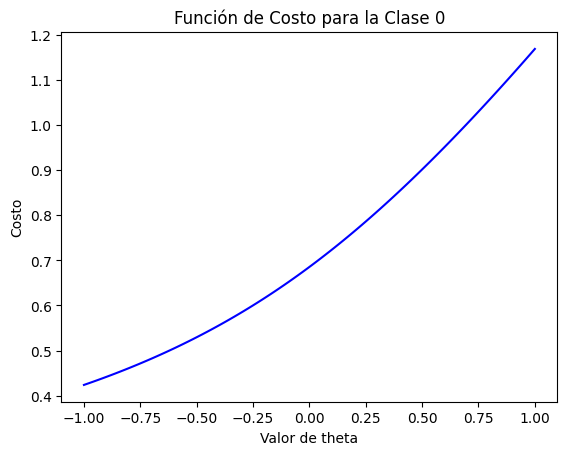

In [36]:
theta_for_class = all_theta[0]
print("Tamaño de theta_for_class:", theta_for_class.shape)
print("Tamaño de X_norm:", X_norm.shape)
print("Número de ejemplos:", Y_train.shape[0])
print("Número de características:", X_norm.shape[1])
cost_values = []
theta_values = np.linspace(-1, 1, 100)
for t in theta_values:
    theta_test = np.copy(theta_for_class)
    theta_test[1] = t
    X_with_intercept = np.concatenate([np.ones((X_norm.shape[0], 1)), X_norm], axis=1)
    cost = plot_cost_function(X_with_intercept, Y_train, theta_test, lambda_)
    cost_values.append(cost)

plt.plot(theta_values, cost_values, 'b-')
plt.xlabel('Valor de theta')
plt.ylabel('Costo')
plt.title('Función de Costo para la Clase 0')
plt.show()

Tamaño de theta_for_class: (55,)
Tamaño de X_norm: (464809, 54)
Número de ejemplos: 464809
Número de características: 54


C:\Users\david\AppData\Local\Temp\ipykernel_19628\2831633526.py:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_19628\1207231430.py:18: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))


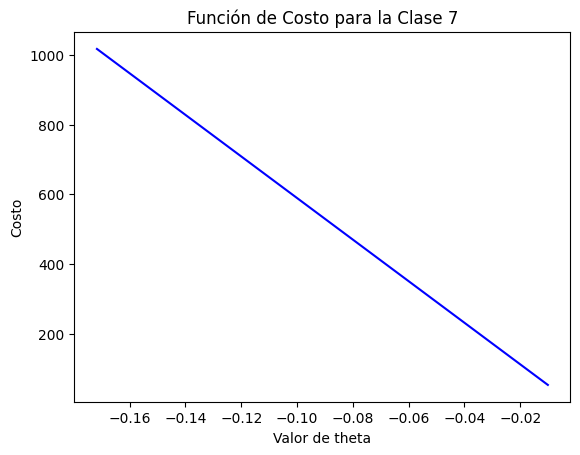

In [37]:
theta_for_class = all_theta[6]  # Clase 7 es el índice 6 (0-indexado)
print("Tamaño de theta_for_class:", theta_for_class.shape)
print("Tamaño de X_norm:", X_train.shape)
print("Número de ejemplos:", Y_train.shape[0])
print("Número de características:", X_train.shape[1])

# Lista para almacenar los valores de costo
cost_values = []
theta_values = np.linspace(-1, 1, 100)

# Calcular el costo para diferentes valores de theta
for t in theta_values:
    theta_test = np.copy(theta_for_class)
    theta_test[1] = t
    X_with_intercept = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
    cost = plot_cost_function(X_with_intercept, Y_train, theta_test, lambda_)
    cost_values.append(cost)

# Graficar la función de costo
plt.plot(theta_values, cost_values, 'b-')
plt.xlabel('Valor de theta')
plt.ylabel('Costo')
plt.title('Función de Costo para la Clase 7')
plt.show()

In [38]:
print(X_test.shape)
pred = predictOneVsAll(all_theta, X_test)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred == y_test) * 100))
m_test = y_test.size
rand_indices = np.random.choice(m_test, 100, replace=False)
XPrueba = X_test[rand_indices, :]
XPruebaV = XPrueba.copy()
print(XPrueba.shape)
XPrueba = np.concatenate([np.ones((100, 1)), XPrueba], axis=1)
print(XPrueba.shape)
p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis = 1)
print(p, y_test[rand_indices])





(116203, 54)
Precision del conjuto de entrenamiento: 60.70%
(100, 54)
(100, 55)
[2 1 2 1 2 1 2 2 2 2 2 2 1 2 1 1 2 2 2 1 1 1 1 2 2 1 2 2 2 1 1 1 1 2 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 2 2 1 2 1 2 1 1
 1 1 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2 2 2] [2 7 2 1 1 1 2 1 1 2 2 2 1 3 1 2 7 2 2 1 1 7 1 2 2 1 3 3 2 1 2 1 2 2 1 2 1
 5 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 1 2 2 7 2 2 2 2 1 2 2 1 3 1 1
 1 1 2 2 2 1 1 2 2 2 1 1 2 1 1 2 2 2 3 1 1 7 1 2 2 2]
